In this file, we aim to investigate the data being considered, as well as perform variable selection.

First, reading in libraries (this is the same across both this file and the actual code file)

In [16]:
# load libraries that may be of use
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import torch
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import random

# seed (idk how necessary this is)
np.random.seed(324324)

Reading in the data, and doing some manipulation to convert "object" instances, as well as converting y_train into proper labels (so a value of 0 would correspond to no answer, as opposed to -1)

In [17]:
# read in the data appropriately
X_train = pd.read_csv("/Users/senadkokic/Desktop/W2024/STAT 841/Final Project/X_train.csv")
y_train = pd.read_csv("/Users/senadkokic/Desktop/W2024/STAT 841/Final Project/Y_train.csv")
X_test = pd.read_csv("/Users/senadkokic/Desktop/W2024/STAT 841/Final Project/X_test.csv")

In [18]:
# conversion from "object" columns to "category" ones
object_columns = X_train.select_dtypes(include=['object']).columns
X_train[object_columns] = X_train[object_columns].astype('category')
label_encoders = {}
for column in X_train.select_dtypes(include=['category']).columns:
    label_encoders[column] = LabelEncoder()
    X_train[column] = label_encoders[column].fit_transform(X_train[column])

object_columns = X_test.select_dtypes(include=['object']).columns
X_test[object_columns] = X_test[object_columns].astype('category')
label_encoders = {}
for column in X_test.select_dtypes(include=['category']).columns:
    label_encoders[column] = LabelEncoder()
    X_test[column] = label_encoders[column].fit_transform(X_test[column])
# get the column names
column_names = X_train.columns
# using a label encoder to use proper class 
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train['label'])

Now, we impute missing values into the data, as some columns have missing entries

In [19]:
# imputing missing values
imputer = SimpleImputer(strategy='mean') 
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)
# reconvert to data frames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
# changing back the column names
X_train = X_train.set_axis(column_names, axis = 1)
X_test = X_test.set_axis(column_names, axis = 1)

Now, using the corr() function in pandas to determine the correlation between each variate:

In [20]:
corr_mat = X_train.corr()

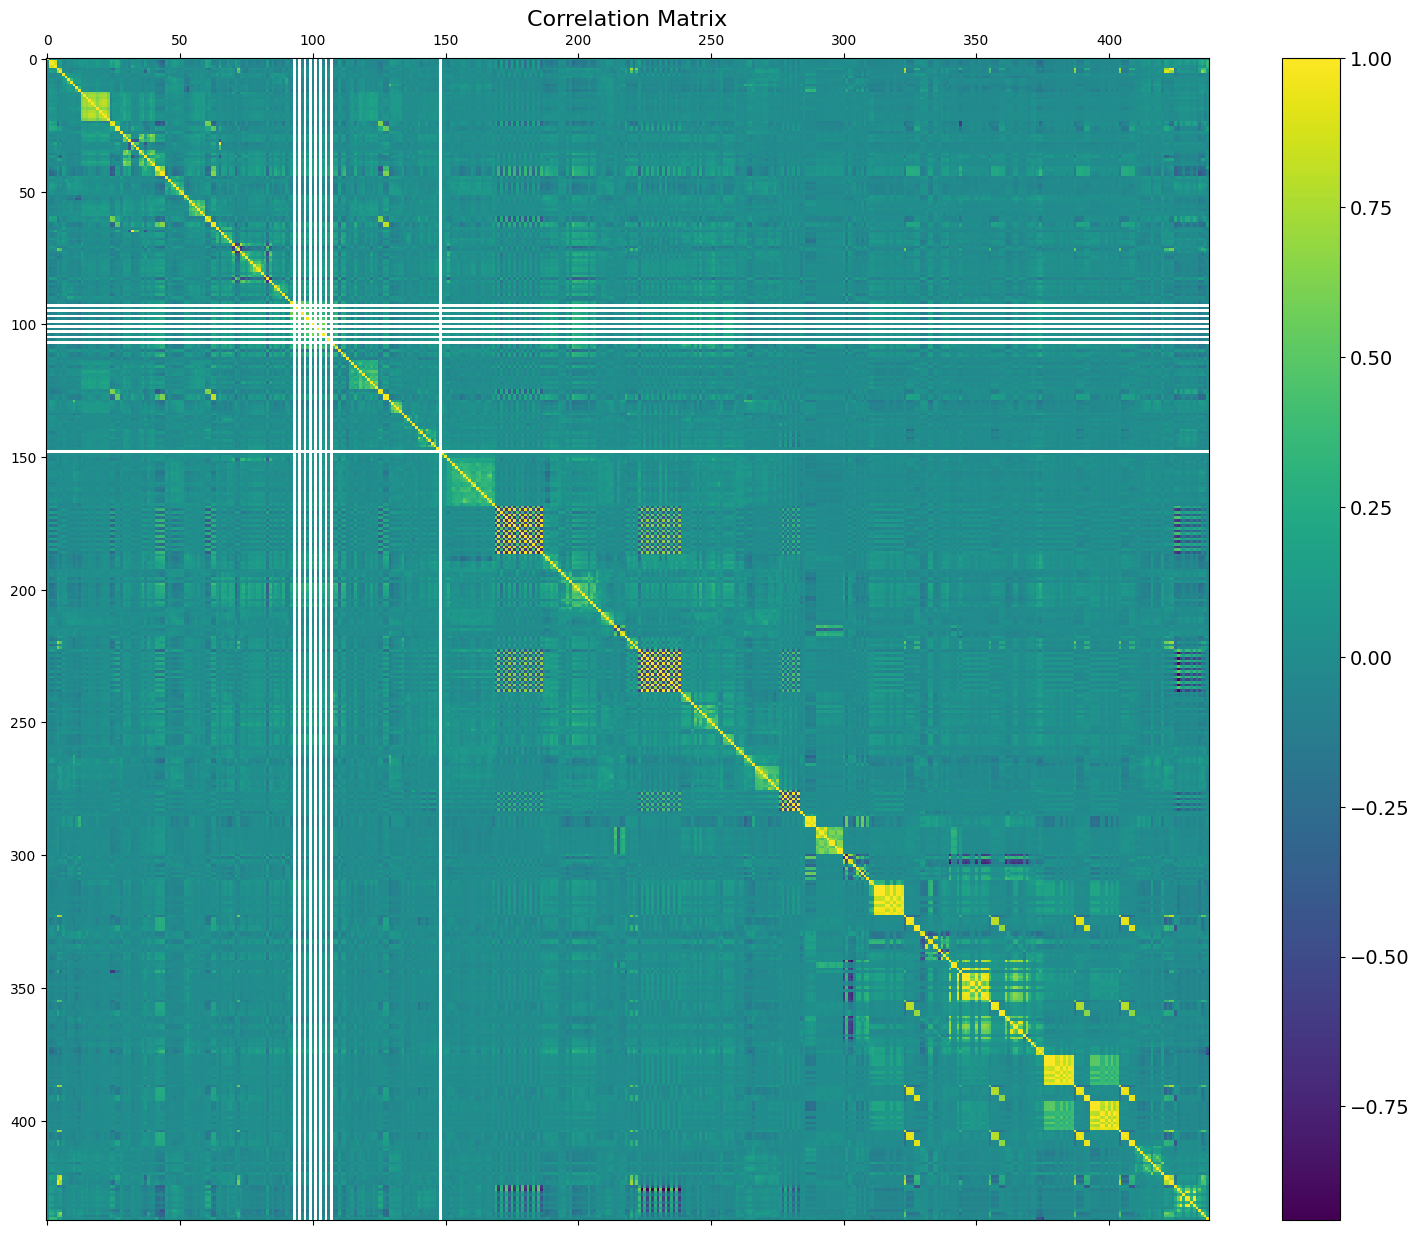

In [29]:
f = plt.figure(figsize=(19, 15))
plt.matshow(corr_mat, fignum=f.number)
#plt.xticks(range(X_train.select_dtypes(['number']).shape[1]), X_train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(X_train.select_dtypes(['number']).shape[1]), X_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Here, we determine the variables with the highest correlation - using a threshold of 0.9

In [24]:
# set threshold
threshold = 0.9

# iterate through to idenfity highly correlated variates
high_correlation_pairs = []
for i in range(len(corr_mat.columns)):
    for j in range(i + 1, len(corr_mat.columns)):
        if abs(corr_mat.iloc[i, j]) > threshold:
            high_correlation_pairs.append((corr_mat.columns[i], corr_mat.columns[j]))

# print variable pairs with correlation higher than the threshold
for pair in high_correlation_pairs:
    print(f"Variables '{pair[0]}' and '{pair[1]}' have a correlation of {corr_mat.loc[pair[0], pair[1]]}.")


In [35]:
print(len(high_correlation_pairs))
bing = []
for pair in high_correlation_pairs:
    print(f"Variables '{pair[0]}' and '{pair[1]}' have a correlation of {corr_mat.loc[pair[0], pair[1]]}.")
    bing.append(pair[0])
print(len(set(bing)))

274
Variables 'year' and 'fw_start' have a correlation of 0.9683226907097561.
Variables 'country' and 'v275c_N2' have a correlation of 0.9804682931885204.
Variables 'country' and 'v275c_N1' have a correlation of 0.9996684147009086.
Variables 'c_abrv' and 'v275b_N2' have a correlation of 0.9014073929435651.
Variables 'c_abrv' and 'v275b_N1' have a correlation of 0.9276640049850929.
Variables 'v20a' and 'v20b' have a correlation of 0.9904634061367535.
Variables 'f24_IT' and 'f46_IT' have a correlation of 0.9977129313295404.
Variables 'f30a' and 'v30a' have a correlation of 0.9380991635827295.
Variables 'v30b' and 'v30c' have a correlation of 0.9613804905175853.
Variables 'v45b' and 'v45c' have a correlation of 0.9750398080857231.
Variables 'f96' and 'v96' have a correlation of 0.9073783598763386.
Variables 'v96a' and 'v96b' have a correlation of 0.9756507937141402.
Variables 'v133_11c' and 'v135_11c' have a correlation of 0.9366607566387762.
Variables 'v133_11c' and 'v136_11c' have a cor

Now, to determine the importance of variates, we use a naive XGBoost model to extract importance, since it is the model we are using.

The model we use here was determined to be the "best" in previous usage. 

In [36]:
model = XGBClassifier(learning_rate = 0.1, max_depth = 4, n_estimators = 400)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
# extract the importance of the variables
imps = model.feature_importances_
# extract the names of the features
feats = X_train.columns
# make a dictionary based on the above
feature_importance_dict = dict(zip(feats, imps))
# sort it out
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

Getting rid of variables with high correlation, keeping the ones with the highest importance. 

In [37]:
for pair in high_correlation_pairs:
    variable_1, variable_2 = pair
    # check if the variables are still there
    if variable_1 in X_train.columns and variable_2 in X_train.columns:
        # keeping the variables with the highest importance
        variable_to_remove = min(pair, key=lambda x: feature_importance_dict.get(x, 0))
        X_train.drop(columns=variable_to_remove, inplace=True)

for pair in high_correlation_pairs:
    variable_1, variable_2 = pair
    # check if the variables are still there
    if variable_1 in X_test.columns and variable_2 in X_test.columns:
        # keeping the variables with the highest importance
        variable_to_remove = min(pair, key=lambda x: feature_importance_dict.get(x, 0))
        X_test.drop(columns=variable_to_remove, inplace=True)

In [38]:
X_train

,id,fw_start,fw_end,country,v1,v2,v3,v4,v5,v7,...,v276_r,v277,v278b,v279a,v279b,v279d_r,v280,v281a,v281a_r,v282
0,0.0,202011.0,202011.0,804.0,2.0,1.0,2.0,2.0,3.0,2.0,...,1.0,20201104.0,45.0,15.0,40.0,55.0,1.0,33.0,475.0,32.0
1,1.0,201809.0,201811.0,688.0,2.0,1.0,2.0,2.0,3.0,2.0,...,3.0,20181129.0,12.0,18.0,25.0,73.0,2.0,32.0,397.0,3.0
2,2.0,201706.0,201803.0,352.0,2.0,2.0,1.0,1.0,2.0,2.0,...,3.0,20170829.0,58.0,13.0,20.0,-5.0,2.0,17.0,72.0,87.0
3,3.0,202105.0,202110.0,428.0,1.0,2.0,1.0,1.0,2.0,2.0,...,5.0,20210829.0,42.0,8.0,51.0,9.0,1.0,21.0,256.0,5157.0
4,4.0,201801.0,201805.0,40.0,1.0,1.0,2.0,2.0,3.0,2.0,...,5.0,20180312.0,51.0,13.0,53.0,62.0,1.0,7.0,158.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,47995.0,201812.0,201903.0,807.0,1.0,1.0,1.0,2.0,2.0,1.0,...,1.0,20190202.0,10.0,14.0,48.0,38.0,1.0,22.0,279.0,1.0
47996,47996.0,201808.0,201812.0,578.0,1.0,1.0,1.0,2.0,2.0,1.0,...,2.0,20181023.0,20.0,16.0,45.0,85.0,1.0,24.0,200.0,1302.0
47997,47997.0,201802.0,201807.0,8.0,2.0,1.0,1.0,2.0,4.0,1.0,...,2.0,20180410.0,40.0,14.0,20.0,40.0,1.0,31.0,13.0,10.0
47998,47998.0,201709.0,201801.0,208.0,2.0,1.0,2.0,2.0,3.0,1.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,6.0,32.0,-4.0


Now, we use Lasso to further trim down. 

In [39]:
# scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
alphas = np.linspace(start = 0.01, stop = 1, num = 100)
lasso = Lasso()
grid_search = GridSearchCV(estimator=lasso, param_grid={'alpha': alphas}, cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print("Best alpha value:", best_alpha)

Best alpha value: 0.01


In [41]:
lasso = Lasso(alpha = best_alpha)
lasso.fit(X_train, y_train)
zero_feats = np.where(np.array(lasso.coef_) == 0.00000000e+00)
zero_feats = zero_feats[0].tolist()
len(zero_feats)

249

Now, since conversions happened, just going to do all of the reading and that again. 

In [62]:
X_train = pd.read_csv("/Users/senadkokic/Desktop/W2024/STAT 841/Final Project/X_train.csv")
X_train = X_train.drop(X_train.columns[zero_feats], axis = 'columns')
X_test = pd.read_csv("/Users/senadkokic/Desktop/W2024/STAT 841/Final Project/X_test.csv")
X_test = X_test.drop(X_test.columns[zero_feats], axis = 'columns')
# conversion from "object" columns to "category" ones
object_columns = X_train.select_dtypes(include=['object']).columns
X_train[object_columns] = X_train[object_columns].astype('category')
label_encoders = {}
for column in X_train.select_dtypes(include=['category']).columns:
    label_encoders[column] = LabelEncoder()
    X_train[column] = label_encoders[column].fit_transform(X_train[column])

object_columns = X_test.select_dtypes(include=['object']).columns
X_test[object_columns] = X_test[object_columns].astype('category')
label_encoders = {}
for column in X_test.select_dtypes(include=['category']).columns:
    label_encoders[column] = LabelEncoder()
    X_test[column] = label_encoders[column].fit_transform(X_test[column])
for pair in high_correlation_pairs:
    variable_1, variable_2 = pair
    # check if the variables are still there
    if variable_1 in X_train.columns and variable_2 in X_train.columns:
        # keeping the variables with the highest importance
        variable_to_remove = min(pair, key=lambda x: feature_importance_dict.get(x, 0))
        X_train.drop(columns=variable_to_remove, inplace=True)

for pair in high_correlation_pairs:
    variable_1, variable_2 = pair
    # check if the variables are still there
    if variable_1 in X_test.columns and variable_2 in X_test.columns:
        # keeping the variables with the highest importance
        variable_to_remove = min(pair, key=lambda x: feature_importance_dict.get(x, 0))
        X_test.drop(columns=variable_to_remove, inplace=True)

We now have 132 variables, compared to the original 438. 

In [67]:
model = XGBClassifier(learning_rate = 0.1, max_depth = 4, n_estimators = 400)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
# extract the importance of the variables
imps = model.feature_importances_
# extract the names of the features
feats = X_train.columns
# make a dictionary based on the above
feature_importance_dict = dict(zip(feats, imps))
# sort it out
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
te = 0
list_bad_feats = []
for feature, importance in sorted_feature_importance:
    if (importance == 0.0):
        print(f"{feature}: {importance}")
        te += 1
        list_bad_feats.append(feature)
# so, we have 3 variables that have 0 importance in the model. We get rid of them 
X_train = X_train.drop(list_bad_feats, axis = 1)
X_test = X_test.drop(list_bad_feats, axis = 1)

v77_DE: 0.0
v78_DE: 0.0
age_r2: 0.0


So, after once again dropping the most unimportant variates, we have 129. 

We write the current X_train and X_test as csvs. 

In [69]:
X_train.to_csv("/Users/senadkokic/Desktop/W2024/STAT 841/Final Project/X_train_cleaned.csv")
X_test.to_csv("/Users/senadkokic/Desktop/W2024/STAT 841/Final Project/X_test_cleaned.csv")